C:\Users\Harri\AppData\Local\Temp\ipykernel_2980\2521176236.py:86: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  coupling_sum = np.sum(Adj[i, j] * np.sin(theta[j] - theta[i]) for j in range(N))


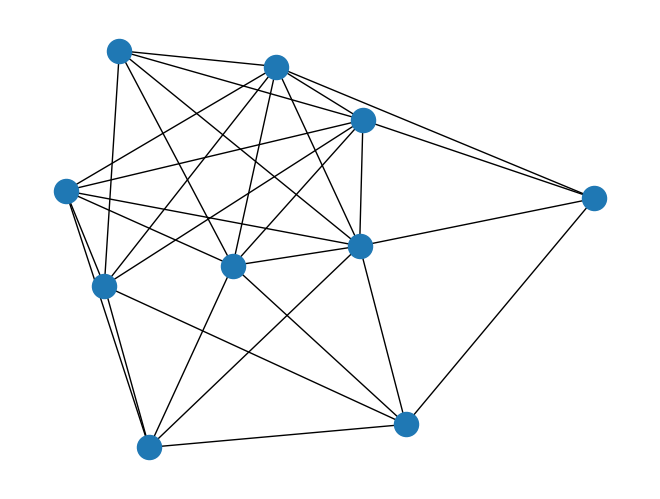

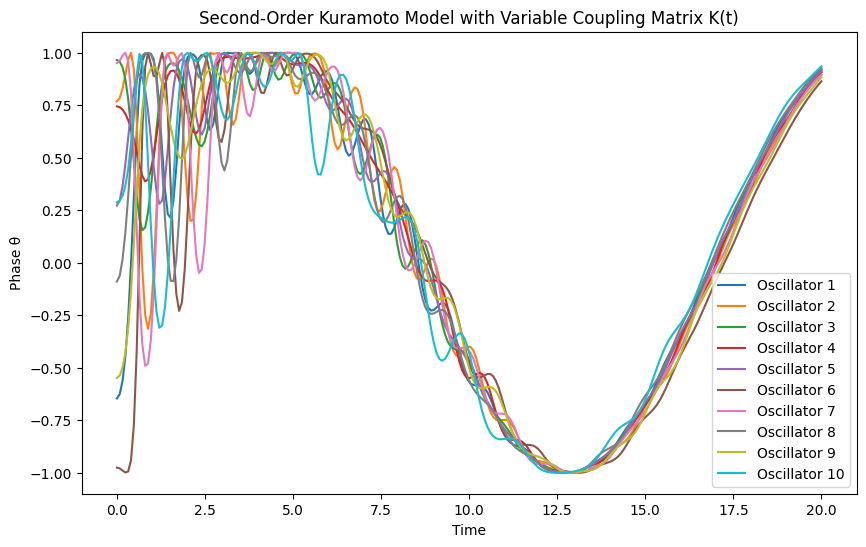

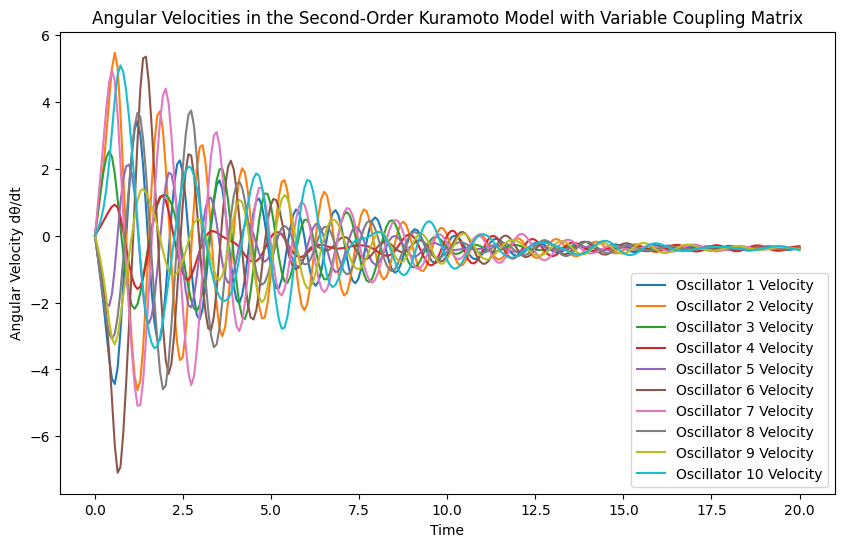

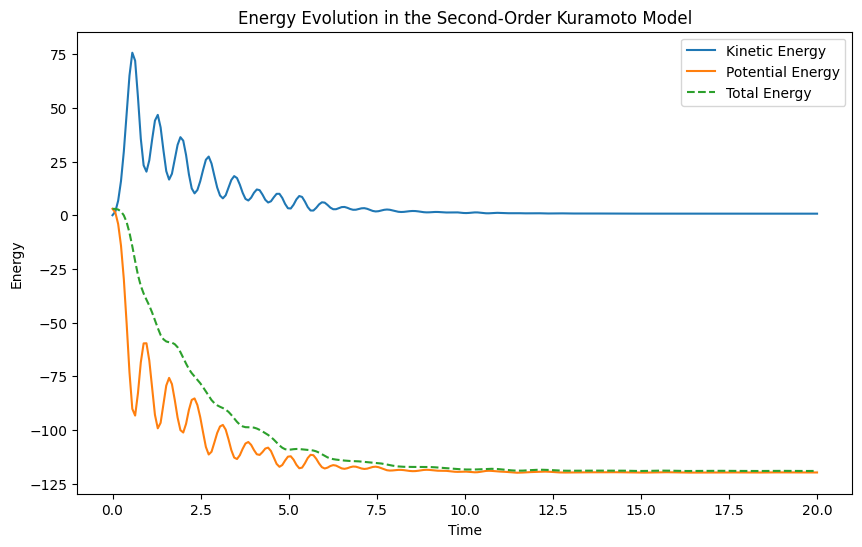

C:\Users\Harri\AppData\Local\Temp\ipykernel_2980\2521176236.py:312: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)
C:\Users\Harri\AppData\Local\Temp\ipykernel_2980\2521176236.py:365: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from matplotlib.gridspec import GridSpec
import os

def GetAdj(N,k,connectivity):
    graph_nx = nx.erdos_renyi_graph(n=N, p=connectivity) # p=1 -> all-to-all connectivity
    adj = nx.to_numpy_array(graph_nx)*k
    nx.draw(graph_nx)
    return adj

def calculate_energy(theta, dtheta_dt, K_matrix, m, N):
    """
    Calculates the kinetic, potential, and total energy of the system.

    Parameters:
    theta : ndarray
        Phases of the oscillators
    dtheta_dt : ndarray
        Angular velocities of the oscillators
    K_matrix : ndarray
        Coupling matrix (NxN)
    m : float
        Inertia of the oscillators
    N : int
        Number of oscillators

    Returns:
    KE : float
        Total kinetic energy
    PE : float
        Total potential energy
    E : float
        Total energy
    """
    # Kinetic energy
    KE = 0.5 * m * np.sum(dtheta_dt**2)
    
    # Potential energy
    PE = 0
    for i in range(N):
        for j in range(i + 1, N):
            PE += -K_matrix[i, j] * np.cos(theta[j] - theta[i])
    
    # Total energy
    E = KE + PE
    return KE, PE, E

def kuramoto_ode_2nd_order_matrix(t, y, omega, Adj, m, gamma, N):
    """
    Defines the ODE system for the second-order Kuramoto model with a variable coupling matrix.

    Parameters:
    t : float
        Current time
    y : ndarray
        Array containing [theta, dtheta_dt] where:
        - theta: phases of the oscillators
        - dtheta_dt: angular velocities of the oscillators
    omega : ndarray
        Array of natural frequencies of the oscillators
    K_func : callable
        Function of time to determine the coupling matrix, K(t) (NxN matrix)
    m : float
        Inertia of the oscillators
    gamma : float
        Damping coefficient
    N : int
        Number of oscillators

    Returns:
    dydt : ndarray
        Derivatives [dtheta_dt, d2theta_dt2]
    """
    theta = y[:N]        # Phases of the oscillators
    dtheta_dt = y[N:]    # Angular velocities

    d2theta_dt2 = np.zeros(N)
   

    # Compute the angular acceleration for each oscillator
    for i in range(N):
        coupling_sum = np.sum(Adj[i, j] * np.sin(theta[j] - theta[i]) for j in range(N))
        d2theta_dt2[i] = ( omega[i] +coupling_sum - gamma * dtheta_dt[i]) / m # omega[i] +
    
    # Return [dtheta_dt, d2theta_dt2] as a flattened array
    return np.concatenate([dtheta_dt, d2theta_dt2])

def solve_kuramoto_2nd_order_matrix(T, theta0, omega, Adj, m, gamma, N, t_eval=None):
    """
    Solves the second-order Kuramoto model using solve_ivp with a variable coupling matrix.

    Parameters:
    T : float
        Final time for the integration
    theta0 : ndarray
        Initial phases of the oscillators
    omega : ndarray
        Natural frequencies of the oscillators
    K_func : callable
        Function of time to determine the coupling matrix, K(t) (NxN matrix)
    m : float
        Inertia of the oscillators
    gamma : float
        Damping coefficient
    N : int
        Number of oscillators
    t_eval : ndarray, optional
        Time points to evaluate the solution (default is None)

    Returns:
    result : OdeResult
        The result object containing the time points and solution.
    """
    # Initial angular velocities (set to zero or random)
    dtheta0 = np.zeros(N)
    # Initial condition vector [theta0, dtheta0]
    y0 = np.concatenate([theta0, dtheta0])
    
    # Time span
    t_span = (0, T)

    # Solving the ODE system
    result = solve_ivp(
        fun=kuramoto_ode_2nd_order_matrix, 
        t_span=t_span, 
        y0=y0, 
        args=(omega, Adj, m, gamma, N),
        t_eval=t_eval, 
        method='RK45'
    )
    
    # Calculate energies at each time step
    KE_values, PE_values, E_values = [], [], []
    for k in range(len(result.t)):
        theta = result.y[:N, k]
        dtheta_dt = result.y[N:, k]
        KE, PE, E = calculate_energy(theta, dtheta_dt, Adj, m, N)
        KE_values.append(KE)
        PE_values.append(PE)
        E_values.append(E)

    return result, np.array(KE_values), np.array(PE_values), np.array(E_values)

def plot_graph_frame(G, pos, adj_matrix, node_phases, phase_changes, frame_path):
    """
    Create and save a graph visualization frame with fixed node positions and varying node phases.

    Parameters:
    - G (networkx.Graph): The graph object created from the adjacency matrix.
    - pos (dict): Precomputed positions for the nodes.
    - adj_matrix (2D list or numpy array): Constant adjacency matrix for the graph.
    - node_phases (list): Phases (in radians, 0 to 2π) for each node.
    - frame_path (str): Path to save the frame image.
    """
    # Normalize node phases to the range [0, 1] for the hsv colormap
    normalized_phases = [(phase % (2 * np.pi)) / (2 * np.pi) for phase in node_phases]
    node_colors = [plt.cm.hsv(np.sin(phase)) for phase in node_phases]

    # Determine edge colors based on adjacency matrix entries
    # edge_weights = [adj_matrix[u][v] for u, v in G.edges()]
    # max_weight = max(edge_weights) if edge_weights else 1
    # min_weight = min(edge_weights) if edge_weights else 0
    # normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
    # edge_colors = [plt.cm.viridis(weight) for weight in normalized_weights]

    fig = plt.figure(figsize=(8, 8))
    # Calculate node sizes based on the degree (number of edges)
    node_sizes = [500 * G.degree(node) for node in G.nodes()]  # Scale factor to adjust node size
    
    # Draw nodes, edges, and labels using fixed positions
    ax0 = fig.add_subplot()
    ax0.set_title("Graph with Tangent Arrows for Phase Changes")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=1, ax=ax0)
    nx.draw_networkx_edges(G, pos, edge_color="black",alpha = 0.7, width=1, ax=ax0)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', ax=ax0)

     # Add tangent arrows indicating phase changes
    itt = 0
    for node, (x, y) in pos.items():
        radius = np.sqrt(node_sizes[node] / 500) * 0.1  # Approximate radius based on node size
        phase_angle = node_phases[node]
        change_magnitude = phase_changes[node]

        # Calculate tangent direction (rotated 90 degrees counter-clockwise)
        tangent_angle = phase_angle + np.pi / 2
        tangent_dx = np.cos(tangent_angle)
        tangent_dy = np.sin(tangent_angle)

        # Arrow direction based on phase change
        dx = change_magnitude * tangent_dx * 0.1
        dy = change_magnitude * tangent_dy * 0.1

        # Plot the arrow at the node's radius (tangent to the node)
        ax0.arrow(
            x + radius * np.cos(phase_angle),
            y + radius * np.sin(phase_angle),
            dx, dy,
            head_width=0.05, head_length=0.1,
            fc='red', ec='red'
        )
        itt += 1
    # for node, (x, y) in pos.items():
    #     radius = np.sqrt(node_sizes[node] / 500) * 0.1  # Approximate radius based on node size
    #     angular_frequency = phase_changes[node]

    #     # Determine the number of winds and direction based on the angular frequency
    #     num_winds = abs(int(angular_frequency))
    #     direction = np.sign(angular_frequency)  # +1 for anti-clockwise, -1 for clockwise

    #     # Create a circular spiral inside the node
    #     theta = np.linspace(0, num_winds * 2 * np.pi, 200)  # 200 points for smoothness
    #     if direction < 0:  # Clockwise
    #         theta = -theta

    #     r = np.linspace(radius, 0, 200)  # Spiral inwards to the center

    #     # Calculate the circular spiral coordinates
    #     spiral_x = x + r * np.cos(theta)
    #     spiral_y = y + r * np.sin(theta)

    #     # Plot the circular spiral
    #     plt.plot(spiral_x, spiral_y, color='red', lw=2)
    
    # Colorbar for node phases
    node_phase_sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=0, vmax=2 * np.pi))
    node_phase_sm.set_array([])
    cbar1 = plt.colorbar(node_phase_sm, ax=plt.gca(), ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    cbar1.ax.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
    cbar1.set_label('Node Phase (radians)')

    # # Colorbar for edge weights
    # edge_weight_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
    # edge_weight_sm.set_array([])
    # plt.colorbar(edge_weight_sm, ax=plt.gca()).set_label('Edge Weight')

    


    # Save the frame
    plt.tight_layout()
    plt.savefig(frame_path)
    plt.close()

def plot_phase_nat_frame(node_phases, phase_hist, nat_hist, frame_path):
     # First extra plot: Line plot of node phases over time
    fig = plt.figure(figsize=(8, 8)) 
    gs = GridSpec(2, 1, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title("Node Phases Over Time")
    for node_idx in range(len(node_phases)):
        #print(np.shape(phase_hist))
        ax1.plot([t[node_idx] for t in phase_hist], label=f"Node {node_idx}")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Phase (radians)")
    ax1.set_ylim(-1,1)
    
    
    
    # Second extra plot: Bar plot of current phase change magnitudes
    ax2 = fig.add_subplot(gs[1])
    # Plotting the angular velocities of each oscillator
    for node_idx in range(len(node_phases)):
        #print(np.shape(nat_hist))
        ax2.plot([t[node_idx] for t in nat_hist], label=f"Node {node_idx}")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Angular Velocity dθ/dt')
    ax2.set_title('Angular Velocities in the Second-Order Kuramoto Model with Variable Coupling Matrix')
    ax2.legend(loc="upper right", fontsize=8)
    

    # Save the frame
    plt.tight_layout()
    plt.savefig(frame_path)
    plt.close()
    
def create_graph_gif(adj_matrix, node_phases_list, nats,output_path, duration=0.5):
    """
    Create a GIF of graphs over time with a fixed adjacency matrix, fixed node positions, and varying node phases.

    Parameters:
    - adj_matrix (2D array): Constant adjacency matrix for the graph.
    - node_phases_list (list of lists): List of node phase lists (in radians, 0 to 2π) for each time point.
    - output_path (str): Path to save the output GIF.
    - duration (float): Duration of each frame in seconds.
    """
    frames_dir = "graph_frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Create a single graph object from the fixed adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))
    
    # Precompute node positions (fixed layout)
    pos = nx.spring_layout(G, seed=42)  # Fix the seed for consistent layout across frames
    frame_paths = []
   
    # Create a frame for each time point

    for t, (node_phases,nats) in enumerate(zip(node_phases_list,nats)):
      
        
        frame_path = os.path.join(frames_dir, f"frame_{t}.png")
        plot_graph_frame(G, pos, adj_matrix, node_phases, nats, frame_path)
        frame_paths.append(frame_path)

    # Create GIF using imageio
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    # # Clean up the frames directory
    # for frame_path in frame_paths:
    #     os.remove(frame_path)
    #     os.rmdir(frames_dir)
    # Clean up the frames directory
    for frame_path in frame_paths:
        os.remove(frame_path)
    for filename in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
def create_plot_gif(adj_matrix, node_phases_list, nats,output_path, duration=0.5):
    """
    Create a GIF of graphs over time with a fixed adjacency matrix, fixed node positions, and varying node phases.

    Parameters:
    - adj_matrix (2D array): Constant adjacency matrix for the graph.
    - node_phases_list (list of lists): List of node phase lists (in radians, 0 to 2π) for each time point.
    - output_path (str): Path to save the output GIF.
    - duration (float): Duration of each frame in seconds.
    """
    frames_dir = "plot_frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Create a single graph object from the fixed adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))
    
    # Precompute node positions (fixed layout)
    pos = nx.spring_layout(G, seed=42)  # Fix the seed for consistent layout across frames
    frame_paths = []
   
    # Create a frame for each time point
    nats_hist = [] 
    phase_hist = []
    for t, (node_phases,nats) in enumerate(zip(node_phases_list,nats)):
        nats_hist.append(nats)
        phase_hist.append(node_phases)
        frame_path = os.path.join(frames_dir, f"frame_{t}.png")
        plot_phase_nat_frame(node_phases, phase_hist, nats_hist,frame_path)
        frame_paths.append(frame_path)

    # Create GIF using imageio
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    # # Clean up the frames directory
    # for frame_path in frame_paths:
    #     os.remove(frame_path)
    #     os.rmdir(frames_dir)
    # Clean up the frames directory
    for frame_path in frame_paths:
        os.remove(frame_path)
    for filename in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e)) 

def plot_colored_graph(adj_matrix, node_phases):
    """
    Create a NetworkX graph from an adjacency matrix and node phases (0 to 2π).
    Nodes are colored based on their phase, and edges are colored based on the adjacency matrix entries.

    Parameters:
    - adj_matrix (2D list or numpy array): Adjacency matrix representing the graph
    - node_phases (list): List of phases (in radians, from 0 to 2π) corresponding to each node

    Returns:
    - G (networkx.Graph): The generated graph
    """

    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))

    # Normalize node phases to the range [0, 1] for the hsv colormap
    normalized_phases = [(phase % (2 * np.pi)) / (2 * np.pi) for phase in node_phases]
    node_colors = [plt.cm.hsv(phase) for phase in normalized_phases]

    # Determine edge colors based on adjacency matrix entries
    edge_weights = [adj_matrix[u][v] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0
    normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
    edge_colors = [plt.cm.viridis(weight) for weight in normalized_weights]

    # Plotting
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Use spring layout for better visualization

    # Draw nodes with colors based on phases
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)

    # Draw edges with colors based on adjacency matrix entries
    edges = nx.draw_networkx_edges(G, pos, edge_color="black", width=2)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Add colorbar for node phases
    node_phase_sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=0, vmax=2 * np.pi))
    node_phase_sm.set_array([])
    cbar1 = plt.colorbar(node_phase_sm, ax=plt.gca(), ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    cbar1.ax.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
    cbar1.set_label('Node Phase (radians)')

    # Add colorbar for edge weights
    edge_weight_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
    edge_weight_sm.set_array([])
    cbar2 = plt.colorbar(edge_weight_sm, ax=plt.gca())
    cbar2.set_label('Edge Weight')

    plt.title("Graph with Colored Nodes (Phases) and Edges (Weights)")
    plt.show()
    
    return G

def GraphGif(adj,phases,nats,gif_query):
    if gif_query == False:
        plot_colored_graph(adj, np.sin(phases[:,0]))
        plot_colored_graph(adj, np.sin(phases[:,-1]))
    else:
        create_graph_gif(adj, np.transpose(np.sin(phases)),np.transpose(nats), "graph_animation.gif", duration=0.5)
        create_plot_gif(adj, np.transpose(np.sin(phases)),np.transpose(nats), "plot_animation.gif", duration=0.5)
        

# Example usage
if __name__ == "__main__":
    res =250
    T = 20  # Simulation time
    m = 1.0 # Inertia of the oscillators
    gamma = 0.5 # Damping coefficient
    np.random.seed(42)  # For reproducibility
    
    N = 10# No. nodes
    k = 4# Coupling strength
    con = 0.6# erdos connectivity probability
    var,mean = 0.7, 0
    
    Adj  = GetAdj(N,k,con)
    # Initial conditions and parameters
    theta0 = np.random.uniform(0, 2 * np.pi, N)   # Random initial phases
    omega = np.random.normal(0, 1, N)             # Natural frequencies from a normal distribution
    t_eval = np.linspace(0, T, res)               # Time points for evaluation

    # Define a variable coupling matrix function, K(t)
   
    # Solving the second-order Kuramoto model with a variable coupling matrix
    result, KE_values, PE_values, E_values = solve_kuramoto_2nd_order_matrix(T, theta0, omega,Adj, m, gamma, N, t_eval)

    # Extracting phases and velocities from the result
    phases = result.y[:N]
    nats = result.y[N:]

    # Plotting the phase evolution of each oscillator
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(result.t, np.sin(phases[i]), label=f'Oscillator {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Phase θ')
    plt.title('Second-Order Kuramoto Model with Variable Coupling Matrix K(t)')
    plt.legend()
    plt.show()

    # Plotting the angular velocities of each oscillator
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(result.t, nats[i], label=f'Oscillator {i+1} Velocity')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity dθ/dt')
    plt.title('Angular Velocities in the Second-Order Kuramoto Model with Variable Coupling Matrix')
    plt.legend()
    plt.show()
    
      # Plotting energy evolution
    plt.figure(figsize=(10, 6))
    plt.plot(result.t, KE_values, label='Kinetic Energy')
    plt.plot(result.t, PE_values, label='Potential Energy')
    plt.plot(result.t, E_values, label='Total Energy', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title('Energy Evolution in the Second-Order Kuramoto Model')
    plt.legend()
    plt.show()

    GraphGif(Adj,phases,nats,gif_query=True)